# TCN (Temporal Convolutional Network)

data: Use a 70/30 split for training and testing.


In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import tensorflow as tf

In [16]:
data = pd.read_csv(r"C:\Users\thunk\Desktop\My Project\Python\DST Prediction\data\data_full.csv")

data.drop(columns = ["Date"] , inplace = True)

data.head()

,D/Q Day,H,D,Z,F,Status,Kp,ap,Ap,Cp,C9,Hp60,DST
0,NaN,32764,-7.125000,33433,46811,def,1.667,6.0,8.0,0.4,2.0,2.333,-16
1,NaN,32767,-7.121667,33431,46811,def,1.667,6.0,8.0,0.4,2.0,2.667,-16
2,NaN,32777,-7.148333,33421,46812,def,1.667,6.0,8.0,0.4,2.0,1.667,-11
3,NaN,32783,-7.190000,33416,46813,def,2.667,12.0,8.0,0.4,2.0,3.000,-11
4,NaN,32790,-7.206667,33426,46825,def,2.667,12.0,8.0,0.4,2.0,3.000,-11


In [17]:
data = pd.get_dummies(data)

data.head()

,H,D,Z,F,Kp,ap,Ap,Cp,C9,Hp60,DST,D/Q Day_D,D/Q Day_Q,Status_def
0,32764,-7.125000,33433,46811,1.667,6.0,8.0,0.4,2.0,2.333,-16,False,False,True
1,32767,-7.121667,33431,46811,1.667,6.0,8.0,0.4,2.0,2.667,-16,False,False,True
2,32777,-7.148333,33421,46812,1.667,6.0,8.0,0.4,2.0,1.667,-11,False,False,True
3,32783,-7.190000,33416,46813,2.667,12.0,8.0,0.4,2.0,3.000,-11,False,False,True
4,32790,-7.206667,33426,46825,2.667,12.0,8.0,0.4,2.0,3.000,-11,False,False,True


In [18]:
y = data["DST"].values
X = data.drop(columns=["DST" , "Status_def"]).values

# Split into training and testing
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X[:-6]
X_test = X[-6:]
y_train = y[:-6]
y_test = y[-6:]

In [19]:
# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

# Reshape for Conv1D input
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


In [20]:
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Dropout, Add, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import mean_squared_error
import numpy as np

def residual_block(x, filters, kernel_size, dilation_rate, dropout_rate=0.1):
    """Defines a single residual block for a TCN."""
    shortcut = x  # Save the input for residual connection
    
    # First convolution
    x = Conv1D(filters, kernel_size, padding='causal', dilation_rate=dilation_rate, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    
    # Second convolution
    x = Conv1D(filters, kernel_size, padding='causal', dilation_rate=dilation_rate, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    
    # Add residual connection
    x = Add()([x, shortcut])
    return x

def build_tcn(input_shape, num_blocks=3, filters=128, kernel_size=2, dropout_rate=0.1):
    """Builds a full TCN model."""
    inputs = Input(shape=input_shape)
    x = inputs
    
    # Stack residual blocks with increasing dilation rates
    for i in range(num_blocks):
        x = residual_block(x, filters, kernel_size, dilation_rate=2**i, dropout_rate=dropout_rate)
    
    # Output layer
    x = Dense(1)(x)  # Single output for regression
    outputs = Lambda(lambda x: x[:, -1, :])(x)  # Extract the last time step
    model = Model(inputs, outputs)
    return model

# Build the TCN model
input_shape = (X_train_reshaped.shape[1], X_train_reshaped.shape[2])
model = build_tcn(input_shape)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.005), loss='mse', metrics=['mae'])

# Callbacks for optimization
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience= 15 , min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1)

with tf.device("/GPU:0"):
    # Train the TCN model
    history = model.fit(
        X_train_reshaped,
        y_train_scaled,
        epochs=200,
        batch_size=32,
        validation_data=(X_test_reshaped, y_test_scaled),
        callbacks=[reduce_lr, early_stopping],
        verbose=1
    )

model.summary()



Epoch 1/200
297/297 [==============================] - 9s 21ms/step - loss: 2.0136 - mae: 0.7695 - val_loss: 0.0727 - val_mae: 0.2579 - lr: 0.0050
Epoch 2/200
297/297 [==============================] - 8s 26ms/step - loss: 0.3752 - mae: 0.4281 - val_loss: 0.0488 - val_mae: 0.1861 - lr: 0.0050
Epoch 3/200
297/297 [==============================] - 7s 25ms/step - loss: 0.2147 - mae: 0.3340 - val_loss: 0.0280 - val_mae: 0.1515 - lr: 0.0050
Epoch 4/200
297/297 [==============================] - 7s 24ms/step - loss: 0.1835 - mae: 0.3062 - val_loss: 0.0415 - val_mae: 0.1882 - lr: 0.0050
Epoch 5/200
297/297 [==============================] - 7s 22ms/step - loss: 0.1597 - mae: 0.2871 - val_loss: 0.1909 - val_mae: 0.4199 - lr: 0.0050
Epoch 6/200
297/297 [==============================] - 8s 26ms/step - loss: 0.1515 - mae: 0.2831 - val_loss: 0.0537 - val_mae: 0.1979 - lr: 0.0050
Epoch 7/200
297/297 [==============================] - 6s 22ms/step - loss: 0.1511 - mae: 0.2773 - val_loss: 0.0431 - 

In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Evaluate the model on test data
y_pred_scaled = model.predict(X_test_reshaped)

# Inverse transform the predictions and actual values
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_actual = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()


# Calculate evaluation metrics
mse = mean_squared_error(y_actual, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_actual, y_pred)
r2 = r2_score(y_actual, y_pred)

# Create a dataframe for the metrics
metrics = {
    "Metric": ["MSE", "RMSE", "MAE", "R²"],
    "Value": [mse, rmse, mae, r2]
}

metrics_table = pd.DataFrame(metrics)

# Print the metrics as a table
print(metrics_table)


1/1 [==============================] - 1s 612ms/step
  Metric     Value
0    MSE  5.496678
1   RMSE  2.344500
2    MAE  2.180562
3     R²  0.636917


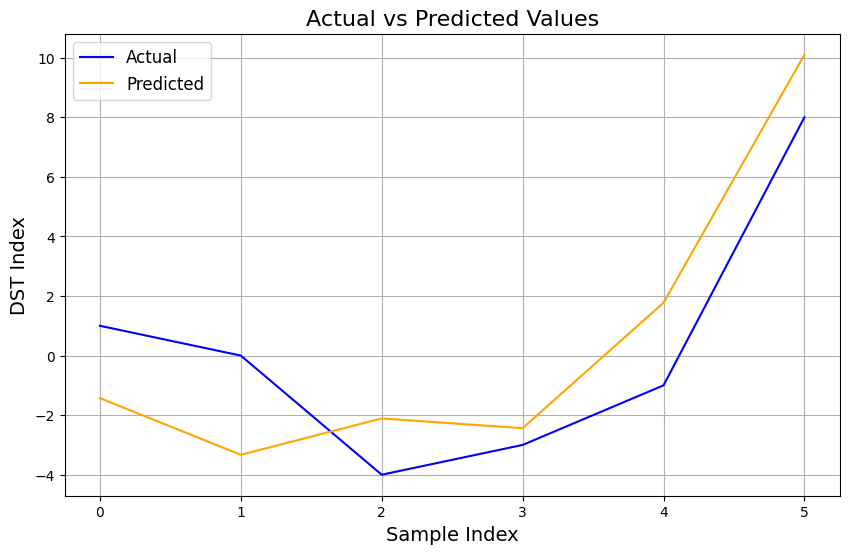

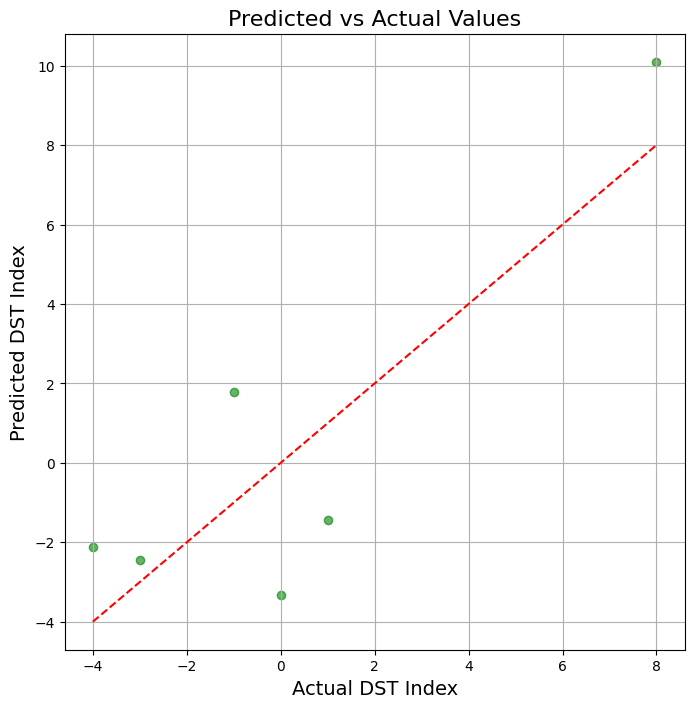

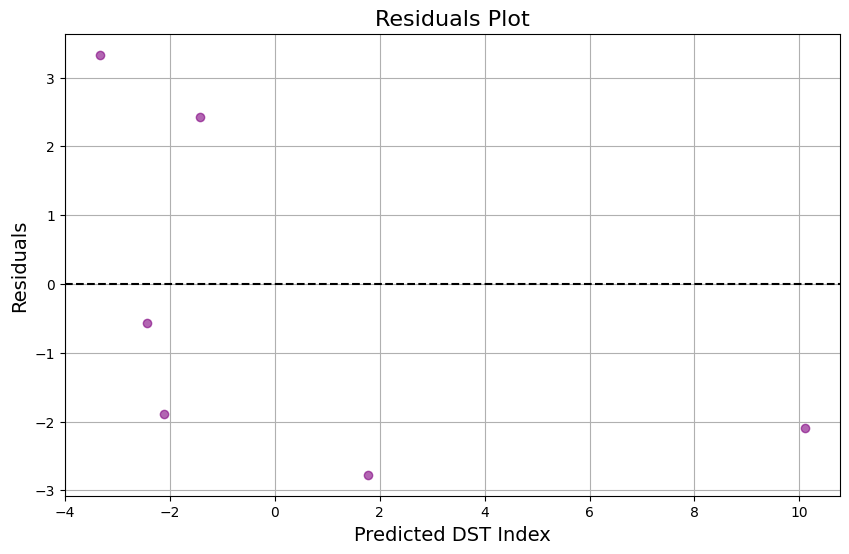

In [22]:



# Plotting actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_actual, label='Actual', color='blue', linewidth=1.5)
plt.plot(y_pred, label='Predicted', color='orange', linestyle='-', linewidth=1.5)
plt.title('Actual vs Predicted Values', fontsize=16)
plt.xlabel('Sample Index', fontsize=14)
plt.ylabel('DST Index', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# Scatter plot for predictions vs actuals
plt.figure(figsize=(8, 8))
plt.scatter(y_actual, y_pred, color='green', alpha=0.6)
plt.plot([min(y_actual), max(y_actual)], [min(y_actual), max(y_actual)], color='red', linestyle='--', linewidth=1.5)
plt.title('Predicted vs Actual Values', fontsize=16)
plt.xlabel('Actual DST Index', fontsize=14)
plt.ylabel('Predicted DST Index', fontsize=14)
plt.grid(True)
plt.show()

# Residual plot
residuals = y_actual - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, color='purple', alpha=0.6)
plt.axhline(0, color='black', linestyle='--', linewidth=1.5)
plt.title('Residuals Plot', fontsize=16)
plt.xlabel('Predicted DST Index', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.grid(True)
plt.show()
